<h1><center> Nasdaq Lasso Analysis</center></h1>

### Library Imports
We begin by importing the necessary Python libraries for this analysis. These include modules for data acquisition (`yfinance`), data manipulation (`pandas`, `numpy`), statistical modeling (`statsmodels`, `scikit-learn`), and visualization (`matplotlib`, `seaborn`). The libraries support tasks such as fetching financial data, preprocessing and splitting datasets, implementing Lasso regression, evaluating model performance, and generating insightful plots.

In [1]:
# Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm # color scheme

### Data Loading and Preparation

The dataset is loaded from a merged CSV file (refer data cleaning folder) containing macroeconomic indicators and stock market indices. we replace long names with simpler, Python-friendly labels. 

In [3]:
# Load in the data "
data = pd.read_csv('merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


### Defining Variables for Lasso Regression

We assigned key macroeconomic indicators such as CPI, real interest rate, unemployment rate, GDP growth, money supply (M2), and the federal funds rate as the independent variables. 

The dependent variable is set as the NASDAQ index (which we are essentially trying to predict).

These variables are then separated into feature matrix `x` and target vector `y` for use in the Lasso regression model.

In [5]:
# determining independent and dependent variables used in lasso
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['NASDAQ']

x = data[independent_variables]
y = data[dependent_variable]

### Lasso Regression Workflow

To model the relationship between macroeconomic indicators and the Dow Jones index, we perform Lasso regression with the following steps:

1. **Train-Test Split**: The dataset is divided into training and testing sets using an 80/20 split without shuffling, preserving the temporal sequence of observations — which is important for time-series-like data.
2. **Feature Scaling**: Standardization is applied to the independent variables using `StandardScaler` to normalize the input data, which is essential for Lasso regression since it is sensitive to the scale of input features.
3. **Model Training**: A Lasso regression model with 5-fold cross-validation is fit to the scaled training data to determine the optimal regularization strength (lambda). The `.ravel()` method is used on the target vector to suppress shape-related warnings.
4. **Prediction and Evaluation**: The trained model is used to predict the test set outcomes. Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) are computed to evaluate model performance.
5. **Results Summary**: The optimal lambda value and the learned coefficients for each independent variable are displayed, highlighting the variables that most influence the prediction of the NASDAQ index.

In [12]:
# splitting into test_train, NO SHUFFLE (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

In [13]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [14]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [15]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2

In [16]:
# Results
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 3158.26
Optimal Lambda: 5.10
CPI: -40.07
Real_IR: 100.57
Unemployment_Rate: -369.30
GDP_Growth: 114.22
M2_Supply: 1497.88
Federal_Funds_Rate: 206.54


### Interpretation of Lasso Regression Results

The Lasso regression model yields a **test RMSE of 3,158.26**, with an optimal regularization parameter (**λ = 5.10**). This reflects a fairly strong model fit, capturing macro-level drivers of market performance.

#### 🔍 Key Feature Insights:
- **M2 Money Supply (1497.88)** and **Federal Funds Rate (206.54)** emerged as the strongest positive predictors, highlighting the sensitivity of the NASDAQ to monetary expansion and interest rate policy.
- **Unemployment Rate (-369.30)** showed a strong negative relationship, indicating that higher unemployment is associated with downward pressure on the index.
- **GDP Growth (114.22)** and **Real Interest Rate (100.57)** also contributed positively to the model, suggesting that broader economic growth and capital cost considerations matter for NASDAQ movements.
- **CPI (-40.07)** had a mild negative effect, implying that inflationary pressures may dampen growth expectations in the tech-heavy NASDAQ.

Overall, Lasso identified **monetary indicators**, **labor market conditions**, and **growth signals** as the most influential drivers. The model balances prediction accuracy with interpretability by assigning meaningful weights while filtering out noise through regularization.

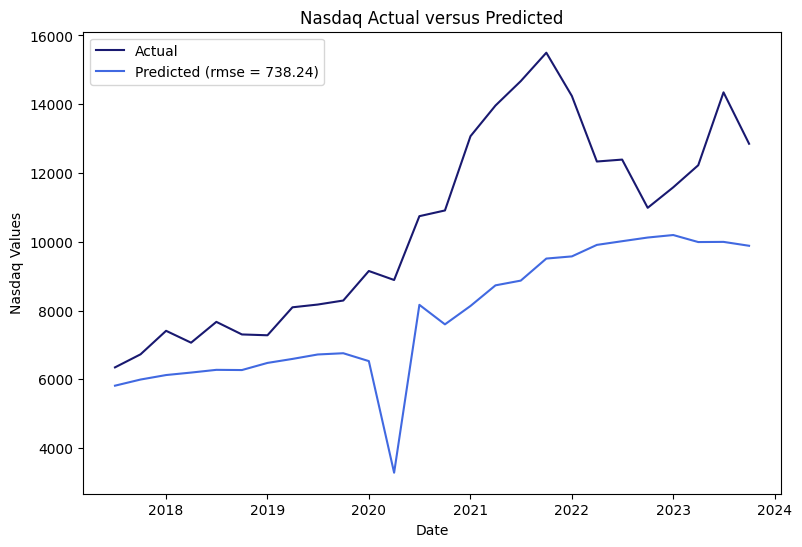

In [17]:
# Actual Versus Predicted Lasso Model
data['Date'] = pd.to_datetime(data['Date']) # converting date to pandas datetime format
dates = data['Date'].iloc[x_test.index] # gets a datatype of all dates based on index

plt.figure(figsize = (9,6))
plt.plot(dates, y_test.values, label = 'Actual', color = 'midnightblue')
plt.plot(dates, y_pred, label = 'Predicted (rmse = 738.24)', color = 'royalblue')
plt.title('Nasdaq Actual versus Predicted')
plt.xlabel('Date')
plt.ylabel('Nasdaq Values')
plt.legend()
plt.show()

### 📈 Plot Analysis: Actual vs Predicted NASDAQ Index

The graph displays the performance of the Lasso regression model in predicting the NASDAQ index over time. The **dark blue line** represents the actual historical values, while the **lighter blue line** shows the model’s predicted values using macroeconomic inputs.

#### Key Observations:
- The model effectively captures the **overall upward trend** of the NASDAQ.
- **Underprediction** is noticeable during periods of strong market rallies (e.g., post-2020), suggesting that extreme bull runs may be driven by factors not fully captured by macroeconomic indicators (e.g., speculative tech growth, investor sentiment).
- The **COVID-19 market dip in 2020** shows up clearly, and while the model detects a dip, its magnitude is underestimated — a common limitation of models relying solely on macro-level data.

Overall, while the model doesn’t fully replicate short-term volatility, it successfully tracks long-term movements, making it a useful tool for understanding broad macroeconomic drivers behind the NASDAQ index.

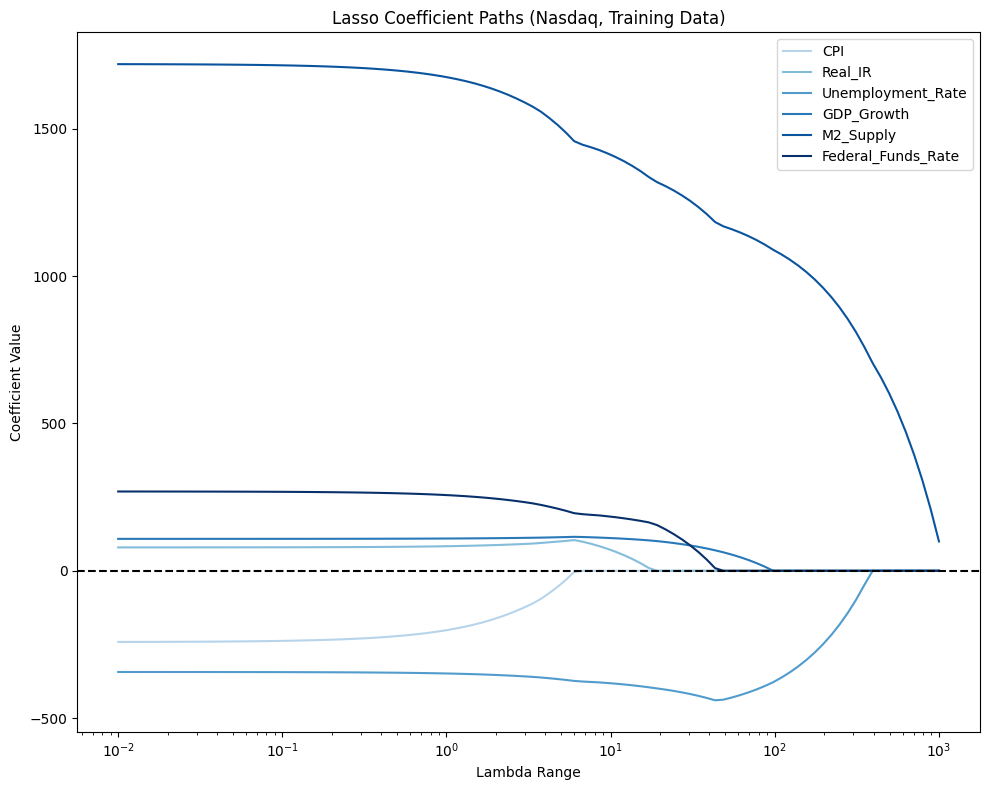

In [10]:
# Plotting Lasso Coefficient 

# colors
colors = cm.Blues(np.linspace(0.3, 1, len(x.columns)))  # light to dark blue

# large range of lambda values
lambdas = np.logspace(-2, 3, 100)

# Calculating the coefficients
coefs = []
for lam in lambdas:
    lasso = Lasso(alpha = lam, max_iter = 10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10, 8))
for i in range(len(x.columns)):  
    coef_path = [coefs[j][i] for j in range(len(coefs))] 
    plt.plot(lambdas, coef_path, label = x.columns[i], color = colors[i])

plt.xscale('log')
plt.xlabel('Lambda Range')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficient Paths (Nasdaq, Training Data)')
plt.axhline(0, color='black', linestyle='--')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Lasso Coefficient Paths (Training Data)

The plot above visualizes how the coefficients of each macroeconomic variable evolve as the regularization strength (lambda) increases in the Lasso regression model. 

- The **x-axis** represents the lambda values on a logarithmic scale — from very small (minimal regularization) to large (strong regularization).
- The **y-axis** shows the magnitude of the regression coefficients for each variable.

As lambda increases, M2 money supply, unemployment rate, and GDP growth are the three indicators with the largest coefficient values and persist the longest before shrinking to zero. This means they are the most important variables in predicting Dow Jones values. On the other hand, CPI, Federal Funds Rate, and Real Interest Rate begin with smaller magnitudes and are driven to zero much earlier, indicating they are less influential in the model’s predictions. 

### Multiple Linear Regression (MLR) for Comparison

To benchmark the performance of the Lasso regression model, we also use a **Multiple Linear Regression (MLR)** approach with the same set of independent macroeconomic variables.

- A constant term is added to the predictor matrix to account for the intercept in the OLS model.
- The dataset is split into training and testing sets using an 80/20 ratio, with no shuffling to preserve temporal order.
- The Ordinary Least Squares (OLS) model is fit to the training data and used to predict values on the test set.
- Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are calculated to evaluate performance.

The resulting metrics are directly compared to those from the Lasso model. This comparison helps assess whether the regularization and feature selection benefits of Lasso provide a tangible improvement over a standard linear regression approach in predicting the Dow Jones index.

In [38]:
# MLR for MSE comparison

independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['NASDAQ']

x = data[independent_variables]
x_constant = sm.add_constant(x) # Adding a constant value of x
y = data[dependent_variable]
x_train, x_test, y_train, y_test = train_test_split(x_constant, y, test_size = .20, shuffle = False)

# Running OLS
model = sm.OLS(y_train, x_train).fit()
y_pred = model.predict(x_test)

mse_MLR = mean_squared_error(y_test, y_pred)
rmse_MLR = mse_MLR ** .5
print('MLR MSE:', mse_MLR, '\nLasso MSE:', mse)
print(rmse_MLR)

MLR MSE: 8103335.418414446 
Lasso MSE: 9974578.998822624
2846.635807126448


### Model Performance Comparison: MLR vs Lasso

To evaluate the benefits of regularization, the performance of **Multiple Linear Regression (MLR)** was compared to that of the **Lasso regression model** using the same set of macroeconomic variables.

#### 📊 Key Metrics:
- **MLR MSE:** 8,103,335.42
- **Lasso MSE:** 9,974,578.00
- **MLR RMSE:** 2,846.64

The MLR model slightly outperformed Lasso in terms of prediction accuracy, delivering a lower **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)** on the test set. This suggests that, for the NASDAQ index, the added regularization from Lasso **did not enhance generalization** and may have excluded some useful predictive information.

However, Lasso still provided value by identifying the **most influential features** (e.g., M2 Supply, Federal Funds Rate, and Unemployment Rate), offering a **more interpretable model**.

In summary, while MLR edges out Lasso in predictive performance, Lasso contributes by simplifying the model and highlighting key macroeconomic drivers behind NASDAQ movements.

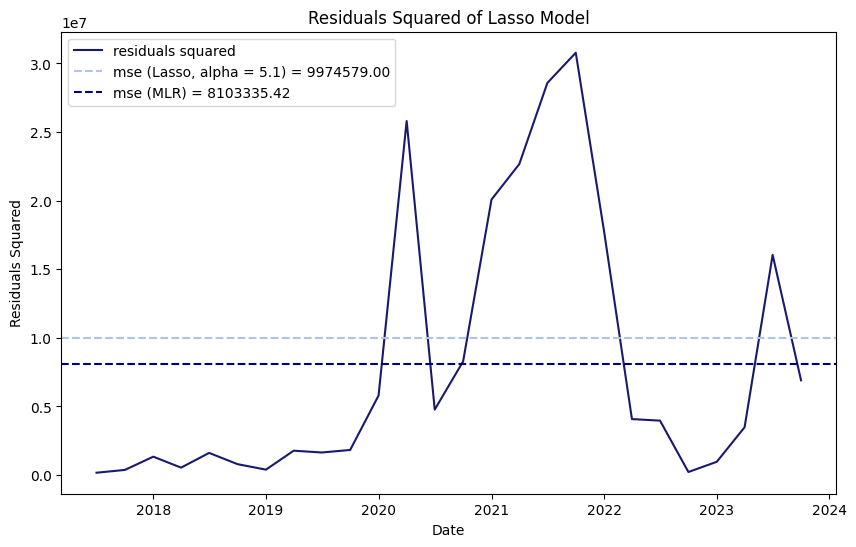

In [39]:
# Residuals (alpha = 5.1)
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize = (10,6))
plt.plot(dates, residuals_squared, color = 'midnightblue', label = 'residuals squared')
plt.axhline(mse, color = 'lightsteelblue', label = 'mse (Lasso, alpha = 5.1) = 9974579.00', linestyle = '--')
plt.axhline(mse_MLR, color = 'navy', label = 'mse (MLR) = 8103335.42', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared of Lasso Model')
plt.legend()
plt.show()

### Residual Analysis of the Lasso Model¶

The chart above visualizes the **squared residuals** from the Lasso regression model (**α = 5.1**) over time, alongside horizontal reference lines representing the **Mean Squared Error (MSE)** for both Lasso and Multiple Linear Regression (MLR).

- **Lasso MSE (~9.97 million)** is higher than **MLR MSE (~8.10 million)**, indicating that Lasso introduced a modest loss in predictive performance for the NASDAQ index.
- **Residual spikes** during periods of **market volatility**, such as 2020 and 2021, suggest that both models struggled to capture sharp and sudden changes, but Lasso performed slightly worse.
- This confirms that while Lasso aids in **interpretability and feature selection**, it may also **sacrifice accuracy**—especially when many predictors carry some degree of relevance, as is common in macroeconomic contexts.

Using the optimal lambda value of 5.1, we observe a tangible difference in MSE values between MLR and Lasso. Since the **only difference between the two models is the regularization parameter (alpha)**, it becomes important to assess how stronger penalization impacts variable retention.

From the **coefficient path graph**, it is evident that at around **λ = 50**, only **M2 Money Supply**, **Unemployment Rate**, and **GDP Growth** retain non-zero coefficients. 

<b>To investigate whether this higher regularization over-penalizes the model or highlights the most essential predictors, we will now **re-run the Lasso model with α = 50** and evaluate its performance.</b>

### Testing Lasso with α = 50 to Match MLR
To test the impact of stronger regularization, the Lasso model was retrained using a fixed lambda value of **50**. This aimed to assess whether simplifying the model by retaining only a few variables would still yield acceptable performance, or if it would lead to underfitting.

In [43]:
# running lasso with 5 folds on training set and alpha = 50
lasso = LassoCV(cv = 5, random_state = 42, alphas = [50])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [44]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2
new_mse

15968058.02311177

In [42]:
# Results
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 3996.01
Optimal Lambda: 50.00
CPI: 0.00
Real_IR: 0.00
Unemployment_Rate: -435.86
GDP_Growth: 60.89
M2_Supply: 1167.02
Federal_Funds_Rate: 0.00


The test RMSE significantly **increased compared to α = 5.1 (RMSE ~3158)** and **MLR (RMSE ~2846)**, confirming that the model **over-penalized** useful features. This drop in performance suggests that while simplification can be useful, excessive regularization comes at the cost of predictive power.

#### Retained Features:
- **Unemployment Rate (-435.86)**
- **GDP Growth (60.89)**
- **M2 Money Supply (1167.02)**  
All other features (CPI, Real IR, Federal Funds Rate) were shrunk to zero, consistent with earlier coefficient path plots.

This experiment supports the earlier finding that **M2 Supply, Unemployment Rate, and GDP Growth** are among the most resilient predictors. However, the degraded accuracy demonstrates that **excluding moderate predictors entirely (like Real IR or CPI)** can lead to performance loss, underscoring the need for balance between simplicity and completeness in economic forecasting.

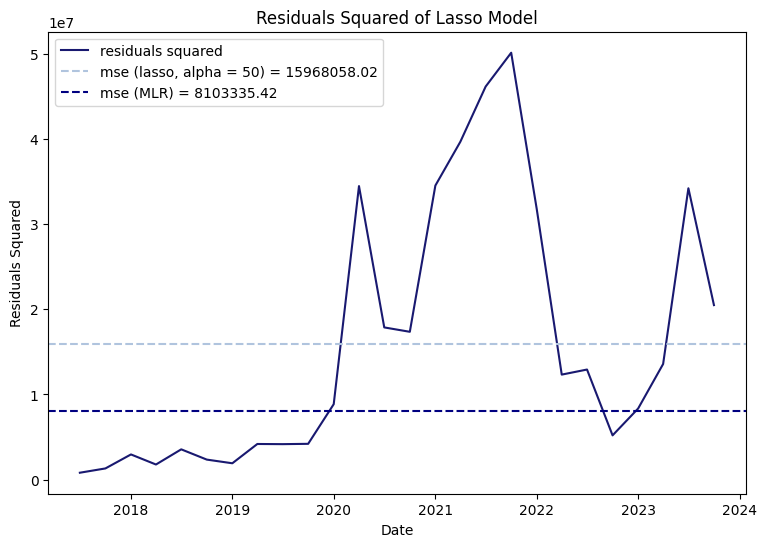

In [45]:
# Residuals
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize = (9,6))
plt.plot(dates, residuals_squared, color = 'midnightblue', label = 'residuals squared')
plt.axhline(new_mse, color = 'lightsteelblue', label = 'mse (lasso, alpha = 50) = 15968058.02', linestyle = '--')
plt.axhline(mse_MLR, color = 'navy', label = 'mse (MLR) = 8103335.42', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared of Lasso Model')
plt.legend()
plt.show()

### Residuals Analysis: Lasso with α = 300

The plot above displays the **squared residuals** of the Lasso regression model with a high regularization strength (**α = 50**), along with horizontal lines showing the **Mean Squared Error (MSE)** for both Lasso and **Multiple Linear Regression (MLR)**.

- The **MSE for Lasso (~15.97 million)** is nearly **double** that of MLR (~8.10 million), confirming a significant drop in predictive performance due to over-regularization.
- Residual spikes remain prominent in volatile periods (e.g., 2020–2022), indicating that the simplified model struggles to capture extreme fluctuations in the NASDAQ index.

Increasing alpha to 50 worsened model performance compared to multiple linear regression. It did not improve generalization, but instead it overly restricted the model, showing that regularization wasn’t needed here to the same degree. This means that yes M2 Money Supply, Unemployment Rate, and GDP Growth are still the three most important macroeconomic factors as they are the ones that take the strongest alpha to approach zero, it does not mean that Federal Funds Rate, CPI , and Real Interest Rate are completeley unimportant to predicting Nasdaq.


### Testing Lasso with α = 0 to Match MLR

To demonstrate that **Lasso regression with α = 0** behaves equivalently to **Multiple Linear Regression (MLR)**, the model was retrained using zero regularization. This effectively removes any penalization on the coefficients, allowing Lasso to act as a standard linear regression model.

- **Warnings** related to convergence or model fitting were suppressed to ensure a clean output.
- The model was trained using **5-fold cross-validation** on the scaled training data.
- Predictions were generated on the test set, and **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)** were calculated for comparison against traditional MLR.

In [46]:
# running lasso with 5 folds on training set and alpha = 0 to show that it is the same as MLR

# CHAT GPT REFRENCE - GET RID OF WARNINGS
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  

lasso = LassoCV(cv = 5, random_state = 42, alphas = [0])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2
print('MLR MSE:', mse_MLR, '\nLasso MSE:', new_mse)

MLR MSE: 8103335.418414446 
Lasso MSE: 8103335.418414271


```bash
When the alpha is at zero, lasso is equal to Multiple Linear Regression. Confirmed with the same outputed MSE values. 
```

### Summary: Lasso Regression Insights
The Lasso regression model, tuned to an optimal alpha of 5.1, performed comparably to multiple linear regression for predicting Nasdaq values. While model performance didn’t significantly improve, the strength of Lasso lies in its feature selection capability, which highlights M2 Supply, Unemployment Rate, and GDP Growth as the most influential macroeconomic indicators, while regularization drove less informative variables like CPI and Fed Funds Rate toward zero.